In [ ]:
# Install the 12.4 cuda toolkit
!wget -qO cuda-keyring.deb https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.1-1_all.deb
!sudo dpkg -i ./cuda-keyring.deb
!sudo apt-get update -y -qq
!sudo apt-get install -y -qq cuda-toolkit-12-4

# Install the necessary prerequisite libraries
!sudo apt install -y libx11-dev libxrandr-dev libxinerama-dev libxcursor-dev libxi-dev mesa-common-dev

# get madrona mjx and its subpackages
!mkdir modules
!git clone https://github.com/shacklettbp/madrona_mjx.git modules/madrona_mjx
!git -C modules/madrona_mjx submodule update --init --recursive

# prepare the build directory
!mkdir modules/madrona_mjx/build

# Configure compilation with CUDA 12.4
!CUDA_HOME=/usr/local/cuda-12.4 CUDAToolkit_ROOT=/usr/local/cuda-12.4 \
 XLA_FLAGS="--xla_gpu_cuda_data_dir=/usr/local/cuda-12.4" \
 PATH="/usr/local/cuda-12.4/bin:$PATH" \
 LD_LIBRARY_PATH="/usr/local/cuda-12.4/lib64:${LD_LIBRARY_PATH}" \
 cmake -S modules/madrona_mjx -B modules/madrona_mjx/build -DLOAD_VULKAN=OFF

# Build
!CUDA_HOME=/usr/local/cuda-12.4 CUDAToolkit_ROOT=/usr/local/cuda-12.4 \
 PATH="/usr/local/cuda-12.4/bin:$PATH" \
 LD_LIBRARY_PATH="/usr/local/cuda-12.4/lib64:${LD_LIBRARY_PATH}" \
 cmake --build modules/madrona_mjx/build -j

# Upgrade numpy and matplotlib
!pip install -U numpy
!pip install -U matplotlib

# Install other prerequisite python libraries
!pip install mujoco
!pip install mujoco_mjx
!pip install brax
!pip install playground
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

# Install Madrona MJX
!pip install -e modules/madrona_mjx

# Clone and install our Quadruped RL package
!git clone https://github.com/alexeiplatzer/unitree-go2-mjx-rl.git
!pip install -e unitree-go2-mjx-rl

(Reading database ... 128663 files and directories currently installed.)
Preparing to unpack ./cuda-keyring.deb ...
Unpacking cuda-keyring (1.1-1) over (1.1-1) ...
Setting up cuda-keyring (1.1-1) ...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 81.)
debconf: falling back to frontend: Readline
Extracting templates from packages: 100%
Selecting previously unselected package cuda-cccl-12-4.
(Reading database ... 128663 files and directories currently installed.)
Preparing to unpack .../00-cuda-cccl-12-4_12.4.127-1_amd64.deb ...
Unpacking cuda-cccl-12-4 (12.4.127-1) ...
Selecting previously unselected package cuda-cupti-12-4.
Preparing to unp

In [ ]:
# Refresh the package if any necessary changes have been pushed. Important in development
repo_path = "./unitree-go2-mjx-rl"
!git -C {repo_path} pull

In [2]:
print("Hi")

Hi


Thu Aug 28 16:51:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

""

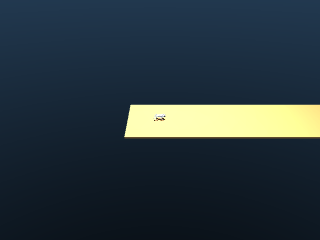

INFO:2025-08-28 16:51:36,625:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-08-28 16:51:36,627:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Setup finished, initializing the environment...


/usr/local/lib/python3.11/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


Using raytracer
Compiling /kaggle/working/modules/madrona_mjx/external/madrona/src/mw/device/bvh.cpp
Compiling /kaggle/working/modules/madrona_mjx/external/madrona/src/mw/device/memory.cpp
Compiling /kaggle/working/modules/madrona_mjx/external/madrona/src/mw/device/host_print.cpp
Compiling /kaggle/working/modules/madrona_mjx/external/madrona/src/mw/device/bvh_raycast.cpp
Compiling GPU engine code:
Initialization finished


In [3]:
# Session setup

import os
# On your second reading, load the compiled rendering backend to save time!
#os.environ["MADRONA_MWGPU_KERNEL_CACHE"] = "/kaggle/working/modules/madrona_mjx/build/cache"
# Ensure that Madrona gets the chance to pre-allocate memory before Jax
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Check if MuJoCo installation was successful
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.'
    )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Prepare paths
from etils.epath import Path
repo_path = Path("unitree-go2-mjx-rl")
configs_path = repo_path / "configs"
scenes_path = repo_path / "resources" / "unitree_go2"
results_path = Path("results")
results_path.mkdir(parents=True, exist_ok=True)

# Prepare configs
from quadruped_mjx_rl.robots import predefined_robot_configs
robot_config = predefined_robot_configs["unitree_go2"]()

from quadruped_mjx_rl.environments import QuadrupedVisionEnvConfig
env_config = QuadrupedVisionEnvConfig(use_vision=False)

from quadruped_mjx_rl.models import TeacherStudentVisionConfig
model_config = TeacherStudentVisionConfig(
    modules=TeacherStudentVisionConfig.ModulesConfig(
        policy=[128, 128, 128, 128],
        value=[256, 256, 256, 256],
        encoder_convolutional=[8, 16, 32],
        encoder_dense=[256, 256],
        adapter_convolutional=[8, 16, 32],
        adapter_dense=[256, 256],
    ),
    latent_size=256,
)

from quadruped_mjx_rl.training.configs import TrainingWithVisionConfig
training_config = TrainingWithVisionConfig(num_timesteps=1_000_000, batch_size=16, num_envs=16, num_eval_envs=16)

from quadruped_mjx_rl.robotic_vision import VisionConfig
vision_config = VisionConfig(render_batch_size=16, render_width=128, render_height=128)

# Set up the terrain
init_scene_path = scenes_path / "scene_mjx_empty_arena.xml"

from quadruped_mjx_rl.environments.physics_pipeline import load_to_spec, spec_to_model
from quadruped_mjx_rl.terrain_gen.obstacles import FlatTile, StripesTile
from quadruped_mjx_rl.terrain_gen.tile import TerrainConfig
flat_tile = FlatTile()
stripes_tile = StripesTile()
terrain = TerrainConfig(tiles=[[flat_tile] * 4 + [stripes_tile] * 4])
print(terrain.tiles)
env_spec = load_to_spec(init_scene_path)
terrain.make_arena(env_spec)
env_model = spec_to_model(env_spec)

# Prepare initial position
x, y, z_offset = terrain.get_tile_center_qpos(0, 0)
init_qpos = env_model.keyframe("home").qpos
init_qpos[0] = x
init_qpos[1] = y
init_qpos[2] += z_offset
print("Main position: " + init_qpos)
print("init qpos type: " + type(init_qpos))

# Render the situation
import mujoco
from quadruped_mjx_rl.environments.rendering import show_image
camera = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(camera)
camera.lookat = [0, 0, 0]
camera.distance = 18
camera.elevation = -30
mj_data = mujoco.MjData(env_model)
mj_data.qpos = init_qpos
with mujoco.Renderer(env_model) as renderer:
    mujoco.mj_forward(env_model, mj_data)
    renderer.update_scene(mj_data, camera=camera)
    image = renderer.render()
show_image(image)

# Craft the env factory
from quadruped_mjx_rl.environments import resolve_env_class, get_env_factory
from quadruped_mjx_rl.robotic_vision import get_renderer
import functools
from jax import numpy as jnp
env_class = resolve_env_class(env_config)
env_model = env_class.customize_model(env_model, env_config)
renderer_maker = functools.partial(get_renderer, vision_config=vision_config)
env_factory = get_env_factory(
    robot_config=robot_config,
    environment_config=env_config,
    env_class=env_class,
    env_model=env_model,
    vision_config=vision_config,
    init_qpos=jnp.array(init_qpos),
    renderer_maker=renderer_maker,
)

# Create the environment
print("Setup finished, initializing the environment...")
env = env_factory()

In [4]:
# Configure logging
import logging
logging.basicConfig(level=logging.INFO, force=True)
logging.info("Logging switched on.")

INFO:root:Logging switched on.


In [ ]:
print((jax.random.split(jax.random.PRNGKey(1), training_config.num_envs)).shape)

In [5]:
# Render visual observations
from quadruped_mjx_rl.environments.wrappers import wrap_for_training
from jax import numpy as jnp
import mediapy as media
import jax

env = wrap_for_training(
    env=env,
    vision=True,
    num_vision_envs=training_config.num_envs,
)
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

state = jit_reset(jax.random.split(jax.random.PRNGKey(43), training_config.num_envs))
#state = jit_reset(jax.random.PRNGKey(42))

state = jit_step(state, jnp.zeros((training_config.num_envs, env.action_size)))

frontal_view = state.obs["pixels/view_frontal_ego"]
print(frontal_view.shape)
terrain_view = state.obs["pixels/view_terrain"]
print(terrain_view.shape)

def tile(img, d):
    assert img.shape[0] == d*d
    img = img.reshape((d,d)+img.shape[1:])
    return np.concat(np.concat(img, axis=1), axis=1)  # replace with 2 for multi-camera tensors!

frontal_view_image = tile(frontal_view[:1], 1)
print(frontal_view_image.shape)
terrain_view_image = tile(terrain_view[:1], 1)
print(terrain_view_image.shape)

media.show_image(frontal_view_image, width=512)
media.show_image(terrain_view_image, width=512)

INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.


XlaRuntimeError: INTERNAL: cuSolver internal error

In [ ]:
!pip show jax

In [ ]:
# Try to launch a vision policy training
from quadruped_mjx_rl.training.train_interface import train
policy_factories, params, metrics = train(
    training_config=training_config,
    model_config=model_config,
    training_env=env,
    evaluation_env=env,
)